# TROCR - Japanese Language

## Required Package

In [ ]:
!pip install -q transformers
!pip install -q datasets jiwer

## Importing required libraries

In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset
from PIL import Image
from transformers import TrOCRProcessor
from transformers import VisionEncoderDecoderModel
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
from transformers import default_data_collator
from datasets import load_metric


## Prepare data

In [ ]:
# Download data using google drive file id
!gdown --id 11TqvOaM8ly07EDyO5dRBzJgmD0AiPuvT 
# Unzip the file- Change the directory according to the training directory
!unzip "/content/dimg.zip" -d '/content/'
BASE_DIR = '/content/新しいフォルダー/'       # Base directory of the unzip folder
# generate text from generated images and create df
training_files = os.listdir(BASE_DIR)
processed_data = pd.DataFrame(training_files, columns = ['file_name'])
#processed_data['words'] = processed_data['filename'].str.split('.jpeg', expand = True)[0]
processed_data['text'] = processed_data['file_name'].str.split('.', expand = True)[0]
df = processed_data.copy()
df.head()

Spliting the data into Train, Test

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state = 42)
# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [ ]:
class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, 
                                          padding="max_length", 
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [ ]:
#from transformers import VisionEncoderDecoderModel

#model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained("google/vit-base-patch16-224-in21k", "cl-tohoku/bert-base-japanese")

# set decoder config to causal lm (only required in case one initializes the decoder with the weights of an encoder-only model)
# this will add the randomly initialized cross-attention layers
#config_decoder.is_decoder = True
#config_decoder.add_cross_attention = True

Initialize the training and evaluation datasets

In [ ]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
train_dataset = IAMDataset(root_dir=BASE_DIR,
                           df=train_df,
                           processor=processor)
                           
eval_dataset = IAMDataset(root_dir=BASE_DIR,
                           df=test_df,
                           processor=processor)

Downloading:   0%|          | 0.00/228 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [ ]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 753
Number of validation examples: 189


Display example of dataset

In [ ]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


Display Image and label


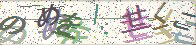

In [ ]:
image = Image.open(train_dataset.root_dir + train_df['file_name'][0]).convert("RGB")
image

In [ ]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

のめをせくこ


## Train a model


In [ ]:
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1")

Downloading:   0%|          | 0.00/4.11k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [ ]:
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    fp16=True, # for CUDA keep this True
    output_dir="./",
    num_train_epochs = 120,
    logging_steps=2,
    save_steps=2000,
    eval_steps=1000,
)

In [ ]:
# Character error rate CER = (S + D + I) / N   > S: substitute, D: Delete, I: insertion, N: total characters
cer_metric = load_metric("cer")

In [ ]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [ ]:
# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)
trainer.train()

Using cuda_amp half precision backend
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 753
  Num Epochs = 120
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11400


Step,Training Loss,Validation Loss,Cer
1000,0.488900,0.511758,0.210884
2000,0.270300,0.326699,0.118562
3000,0.256300,0.446280,0.111759
4000,0.035300,0.557071,0.080661
5000,0.050300,0.752312,0.076774
6000,0.065800,0.861655,0.103984
7000,0.000800,1.006792,0.088435
8000,0.000100,1.135659,0.060253


***** Running Evaluation *****
  Num examples = 189
  Batch size = 8
***** Running Evaluation *****
  Num examples = 189
  Batch size = 8
Saving model checkpoint to ./checkpoint-2000
Configuration saved in ./checkpoint-2000/config.json
Model weights saved in ./checkpoint-2000/pytorch_model.bin
Feature extractor saved in ./checkpoint-2000/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 189
  Batch size = 8
***** Running Evaluation *****
  Num examples = 189
  Batch size = 8
Saving model checkpoint to ./checkpoint-4000
Configuration saved in ./checkpoint-4000/config.json
Model weights saved in ./checkpoint-4000/pytorch_model.bin
Feature extractor saved in ./checkpoint-4000/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 189
  Batch size = 8
***** Running Evaluation *****
  Num examples = 189
  Batch size = 8
Saving model checkpoint to ./checkpoint-6000
Configuration saved in ./checkpoint-6000/config.json
Model weights saved in ./checkpoin

### Loading trained Model

In [ ]:
#  model.save_pretrained("./models")
#  processor.save_pretrained('./models')
#  pro = TrOCRProcessor.from_pretrained("./models")
#  processor = TrOCRProcessor.from_pretrained("./checkpoint-200")
#  model1 = VisionEncoderDecoderModel.from_pretrained("./checkpoint-100")
#  file_name = df['file_name'][8]
# text = df['text'][8]
# image = Image.open(BASE_DIR + file_name).convert("RGB")
# pixel_values = pro(image, return_tensors="pt").pixel_values
# pro.batch_decode(model1.generate(pixel_values), skip_special_tokens=True)[0]

## Predictions


In [ ]:
def text_prediction(file_name, BASE_DIR, device, model, processor):
  image = Image.open(BASE_DIR + file_name).convert("RGB")
  pixel_values = processor(image, return_tensors="pt").pixel_values
  generated_ids = model.generate(pixel_values.to(device))
  generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
  return generated_text


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
pred = []
for i in df.index:
  pred.append(text_prediction(df['file_name'][i], BASE_DIR, device, model, processor))

In [ ]:
predicted_df = df.copy()
predicted_df['predicted text'] = pred

In [ ]:
predicted_df.head(100)

,file_name,text,predicted text
0,あねんや.jpeg,あねんや,わふぬわ
1,よさせにきぬ.png,よさせにきぬ,わそふねにみわ
2,えいせうにお.png,えいせうにお,ちふぬうけねむ
3,めぬそつさ.png,めぬそつさ,ややふへねつ
4,やいしお.png,やいしお,ゆふぬ
...,...,...,...
95,たみなろいまれ.png,たみなろいまれ,ねそわぬせそつ
96,むおのて.png,むおのて,つへぬわの
97,さろさめそひけ.png,さろさめそひけ,されゆろむねそね
98,つせそのふ.png,つせそのふ,のふおののむ


In [ ]:
predicted_df.to_csv('predictions.csv')

## Loading Trained Model

In [ ]:
from transformers import VisionEncoderDecoderModel

model1 = VisionEncoderDecoderModel.from_pretrained("./trained_model")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)